In [76]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 
import time

In [77]:
gdf  = gpd.read_file('boundary/geo_export_bb32215a-26c7-4206-ae1f-02e0227a5383.shp')

In [78]:
gdf

,objectid,shape_area,shape_len,zip,geometry
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917..."
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922..."
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909..."
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895..."
...,...,...,...,...,...
56,57.0,1.552855e+08,53406.915617,60623,"POLYGON ((-87.69479 41.83008, -87.69486 41.830..."
57,58.0,2.111148e+08,58701.325375,60629,"POLYGON ((-87.68306 41.75786, -87.68306 41.757..."
58,59.0,2.116961e+08,58466.160298,60620,"POLYGON ((-87.62373 41.72167, -87.62388 41.721..."
59,60.0,1.254243e+08,52377.854541,60637,"POLYGON ((-87.57691 41.79511, -87.57700 41.795..."


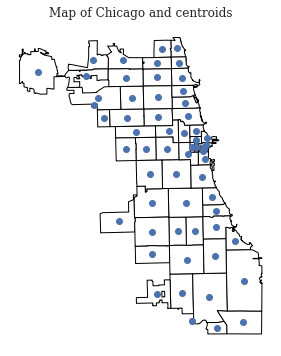

In [79]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(color = 'white', edgecolor = 'black', ax = ax)
gdf.centroid.plot(ax=ax)
ax.set_title('Map of Chicago and centroids', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [80]:
crime_df = pd.read_csv('crime_2012_2022.csv', sep='\t')

In [81]:
crime_2018_df = crime_df[crime_df.Year == 2018]
crime_2018_df.dropna(inplace = True)

In [82]:
crime_zip_df = crime_2018_df.groupby(['Boundaries - ZIP Codes'])['Boundaries - ZIP Codes'].count().to_frame()

In [83]:
crime_zip_df.index.name = 'zip'
crime_zip_df.rename(columns={"Boundaries - ZIP Codes" : "crime_num"},inplace=True)

In [84]:
crime_zip_df.index = 60600 + crime_zip_df.index
crime_zip_df.index = crime_zip_df.index.astype(int)

In [85]:
gdf.zip = gdf.zip.astype(int)

In [86]:
train_df = gdf.merge(crime_zip_df,on='zip',how='inner')

In [87]:
pop_df = pd.read_csv('Chicago_Population_Counts.csv')

In [88]:
pop_2018_df = pop_df[pop_df.Year == 2018]

In [89]:
pop_2018_df = pop_2018_df.iloc[1:]
pop_2018_df.Geography = pop_2018_df.Geography.astype(int)

# School

In [90]:
schoold_df = pd.read_csv('Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv')

In [91]:
school_zip_df = schoold_df.groupby('Zip')['Zip'].count().to_frame()

In [92]:
school_zip_df.index.name = 'zip'
school_zip_df.rename(columns={"Zip" : "school_num"},inplace=True)

# Police station

In [93]:
police_df = pd.read_csv('Police_Stations.csv')

In [94]:
police_zip_df = police_df.groupby('ZIP')['ZIP'].count().to_frame()

In [95]:
police_zip_df.index.name = 'zip'
police_zip_df.rename(columns={"ZIP" : "station_num"},inplace=True)

# Business

In [96]:
businnes_df = pd.read_csv('Business_Licenses_-_Current_Active.csv')
businnes_df = businnes_df[businnes_df.CITY == 'CHICAGO']

In [97]:
businnes_zip_df = businnes_df.groupby('ZIP CODE')['ZIP CODE'].count().to_frame()

In [98]:
businnes_zip_df.index = businnes_zip_df.index.astype(int)
businnes_zip_df.index.name = 'zip'
businnes_zip_df.rename(columns={"ZIP CODE" : "business"},inplace=True)


# Housing

In [99]:
house_df = pd.read_csv('Affordable_Rental_Housing_Developments.csv')

In [100]:

house_zip_df = house_df.groupby('Zip Code')['Zip Code'].count().to_frame()
house_zip_df.index = house_zip_df.index.astype(int)
house_zip_df.index.name = 'zip'
house_zip_df.rename(columns={"Zip Code" : "house"},inplace=True)

# Population and Density

In [101]:
pop_df = pd.read_csv('uszips.csv')

In [102]:
pop_df = pop_df[pop_df['city'].isin(['Chicago','West Chicago','Chicago Heights','Chicago Ridge'])]

In [103]:
pop_df.columns

Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone'],
      dtype='object')

# Income

In [104]:
income_df = pd.read_csv('tax.csv', sep = ',',thousands=',')

In [105]:
income_df.columns =['zip','category','tax',"unname"]

In [106]:
income_df.drop(columns=['unname'],inplace=True)

In [107]:
income_df.dropna(axis=0,inplace=True)

In [108]:
income_new_df = income_df.groupby(['zip','category']).sum().unstack('category')

In [109]:
income_new_df.columns = ['level1','level2','level3','level4','level5','level6']

In [110]:
income_new_df

,level1,level2,level3,level4,level5,level6
zip,,,,,,
00000,24408351.0,126311367.0,190664028.0,51280648.0,53935928.0,50642741.0
60002,39633.0,363149.0,280901.0,81127.0,105258.0,113188.0
60004,67950.0,925611.0,1393884.0,157540.0,208326.0,232871.0
60005,46654.0,440898.0,747543.0,108779.0,137657.0,126502.0
60007,57428.0,509399.0,318522.0,146777.0,191847.0,179638.0
...,...,...,...,...,...,...
62995,7254.0,31909.0,0.0,15305.0,16459.0,14737.0
62996,1016.0,3001.0,0.0,2025.0,2781.0,3206.0
62998,732.0,0.0,0.0,1342.0,1672.0,3495.0


In [111]:
income_new_df.fillna(0, inplace=True)

In [112]:
income_new_df.index = income_new_df.index.astype(int)

# Concat

In [113]:
train_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    57 non-null     float64 
 1   shape_area  57 non-null     float64 
 2   shape_len   57 non-null     float64 
 3   zip         57 non-null     int64   
 4   geometry    57 non-null     geometry
 5   crime_num   57 non-null     int64   
dtypes: float64(3), geometry(1), int64(2)
memory usage: 3.1 KB


In [114]:
train_df = train_df.merge(pop_2018_df,left_on='zip',how='inner',right_on='Geography')
train_df = train_df.merge(school_zip_df,on='zip',how='left')

In [115]:
train_df = train_df.merge(pop_df,on='zip',how='left')

In [116]:
train_df = train_df.merge(police_zip_df,on='zip',how='left')

In [117]:
train_df = train_df.merge(businnes_zip_df,on='zip',how='left')

In [118]:
train_df = train_df.merge(house_zip_df,on='zip',how='left')

In [119]:
train_df = train_df.merge(income_new_df,on='zip',how='left')

In [120]:
train_df.fillna(0,inplace=True)

In [121]:
# for i in ['level1','level2','level3','level4','level5','level6']:
#     train_df[i] = train_df[i] / train_df['Population - Total']

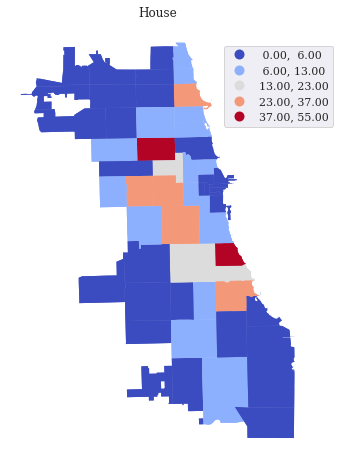

In [183]:
fig, ax = plt.subplots(figsize=(8, 8))
train_df.plot(column='house', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
#gdf.plot(column='PctBach', cmap = 'coolwarm', linewidth=0.01, scheme = 'box_plot', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('House', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

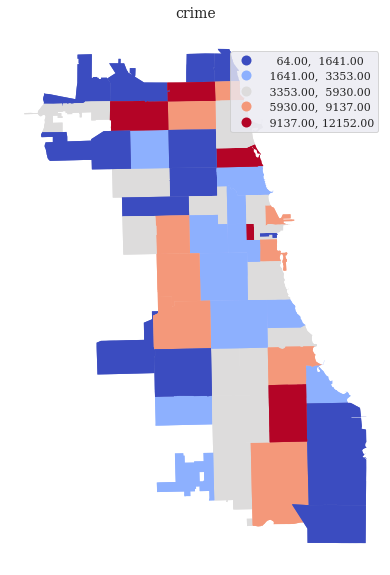

In [123]:
fig, ax = plt.subplots(figsize=(10, 10))
train_df.plot(column='crime_num', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.0, 0.96)},  ax=ax)
#gdf.plot(column='PctBach', cmap = 'coolwarm', linewidth=0.01, scheme = 'box_plot', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('crime', fontsize=14)
ax.axis("off")
plt.savefig('crime.png',dpi=400, bbox_inches='tight')
plt.show()

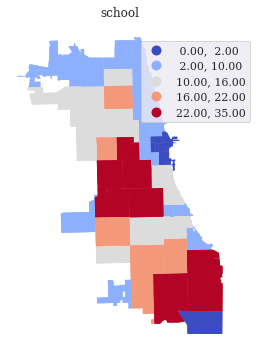

In [124]:
fig, ax = plt.subplots(figsize=(6, 6))
train_df.plot(column='school_num', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
#gdf.plot(column='PctBach', cmap = 'coolwarm', linewidth=0.01, scheme = 'box_plot', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('school', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

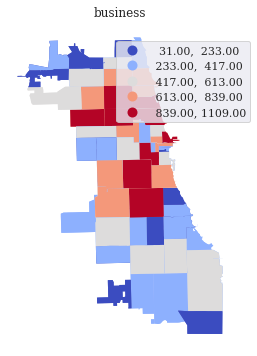

In [125]:
fig, ax = plt.subplots(figsize=(6, 6))
train_df.plot(column='business', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
#gdf.plot(column='PctBach', cmap = 'coolwarm', linewidth=0.01, scheme = 'box_plot', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('business', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

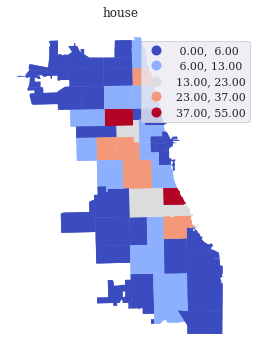

In [126]:
fig, ax = plt.subplots(figsize=(6, 6))
train_df.plot(column='house', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
#gdf.plot(column='PctBach', cmap = 'coolwarm', linewidth=0.01, scheme = 'box_plot', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('house', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [127]:
train_df.columns

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry', 'crime_num',
       'Geography Type', 'Year', 'Geography', 'Population - Total',
       'Population - Age 0-17', 'Population - Age 18-29',
       'Population - Age 30-39', 'Population - Age 40-49',
       'Population - Age 50-59', 'Population - Age 60-69',
       'Population - Age 70-79', 'Population - Age 80+',
       'Population - Age 0-4', 'Population - Age 5-11',
       'Population - Age 12-17', 'Population - Age 5+', 'Population - Age 18+',
       'Population - Age 65+', 'Population - Female', 'Population - Male',
       'Population - Latinx', 'Population - Asian Non-Latinx',
       'Population - Black Non-Latinx', 'Population - White Non-Latinx',
       'Population - Other Race Non-Latinx', 'Record ID', 'school_num', 'lat',
       'lng', 'city', 'state_id', 'state_name', 'zcta', 'parent_zcta',
       'population', 'density', 'county_fips', 'county_name', 'county_weights',
       'county_names_all', 'county_fips_all'

In [128]:
zone = train_df.to_crs(epsg=4326)
zone.crs
zone['centro']=zone.centroid
zone['X']=zone.centro.x
zone['Y']=zone.centro.y
coords = list(zip(zone['X'],zone['Y']))

In [129]:
y = train_df['crime_num'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(114, 1)

In [130]:
X = train_df[['school_num','Population - Latinx','station_num', 'business','house','density','population','level1','level2','level3','level4','level5','level6']].values
X.shape

(114, 13)

In [131]:
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

In [132]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 114
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       885001114.037
Log-likelihood:                                                   -1066.058
AIC:                                                               2160.117
AICc:                                                              2167.015
BIC:                                                           885000640.417
R2:                                                                   0.186
Adj. R2:                                                              0.080

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ----

In [133]:
print('Mean R2 =', gwr_results.R2)
print('AIC =', gwr_results.aic)
print('AICc =', gwr_results.aicc)

Mean R2 = 0.7393250748289463
AIC = 2075.2162257844334
AICc = 2110.919440882336


In [134]:
Zy = (y - y.mean(axis=0)) / y.std(axis=0)
ZX = (X - X.mean(axis=0)) / X.std(axis=0)

In [135]:
mgwr_selector = Sel_BW(coords, Zy, ZX, multi=True)
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)
mgwr_results = MGWR(coords, Zy, ZX, mgwr_selector).fit()
mgwr_results.summary()


Backfitting: 100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


[112.  70.  44.  46.  65. 112. 112. 112. 112. 112. 112. 112. 112.  76.]


Inference: 100%|██████████| 1/1 [00:09<00:00,  9.43s/it]

Model type                                                         Gaussian
Number of observations:                                                 114
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             92.814
Log-likelihood:                                                    -150.040
AIC:                                                                328.080
AICc:                                                               334.978
BIC:                                                               -380.805
R2:                                                                   0.186
Adj. R2:                                                              0.080

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [136]:
['school_num','Population - Latinx','station_num', 'business','house','density','population','level1','level2','level3','level4','level5','level6']

['school_num',
 'Population - Latinx',
 'station_num',
 'business',
 'house',
 'density',
 'population',
 'level1',
 'level2',
 'level3',
 'level4',
 'level5',
 'level6']

In [137]:
train_df['gwr_intercept'] = gwr_results.params[:,0]
train_df['gwr_sc'] = gwr_results.params[:,1]
train_df['gwr_pop'] = gwr_results.params[:,2]
train_df['gwr_st'] = gwr_results.params[:,3]
train_df['gwr_bus'] = gwr_results.params[:,4]
train_df['gwr_house'] = gwr_results.params[:,5]
train_df['gwr_density'] = gwr_results.params[:,6]

train_df['gwr_population'] = gwr_results.params[:,7]
train_df['gwr_level1'] = gwr_results.params[:,8]
train_df['gwr_level2'] = gwr_results.params[:,9]
train_df['gwr_level3'] = gwr_results.params[:,10]
train_df['gwr_level4'] = gwr_results.params[:,11]
train_df['gwr_level5'] = gwr_results.params[:,12]
train_df['gwr_level6'] = gwr_results.params[:,13]


#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

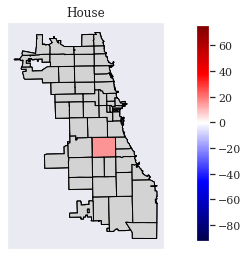

In [175]:
fig, axes = plt.subplots()
ax0 = axes
ax0.set_title('House')


#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = train_df['gwr_house'].min()
gwr_max = train_df['gwr_house'].max()

vmin = gwr_min
vmax = gwr_max

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
train_df.plot('house', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,5] == 0).any():
    train_df[gwr_filtered_t[:,5] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})
 
#Set figure options and plot 
fig.tight_layout()    
fig.subplots_adjust(right=1.3)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params() 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
plt.show()

# plt.savefig('population.png',dpi = 300,bbox_inches='tight')


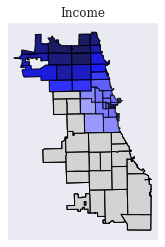

In [180]:
fig, axes = plt.subplots()
ax0 = axes
ax0.set_title('Income')


#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = train_df['gwr_level3'].min()
gwr_max = train_df['gwr_level3'].max()

vmin = gwr_min
vmax = gwr_max

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
train_df.plot('gwr_level3', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,10] == 0).any():
    train_df[gwr_filtered_t[:,10] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})
 
#Set figure options and plot 
# fig.tight_layout()    
# fig.subplots_adjust(right=1.3)
# cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
# sm._A = []
# cbar = fig.colorbar(sm, cax=cax)
# cbar.ax.tick_params() 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
plt.show()


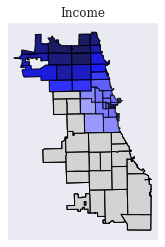

In [179]:
fig, axes = plt.subplots()
ax0 = axes
ax0.set_title('Income')


#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = train_df['gwr_level3'].min()
gwr_max = train_df['gwr_level3'].max()

vmin = gwr_min
vmax = gwr_max

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
train_df.plot('gwr_level3', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,10] == 0).any():
    train_df[gwr_filtered_t[:,10] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})
 
#Set figure options and plot 
# fig.tight_layout()    
# fig.subplots_adjust(right=1.3)
# cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
# sm._A = []
# cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params() 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
plt.show()


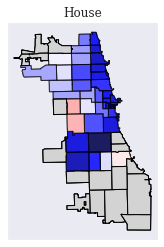

In [182]:
fig, axes = plt.subplots()
ax0 = axes
ax0.set_title('House')


#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = train_df['gwr_house'].min()
gwr_max = train_df['gwr_house'].max()

vmin = gwr_min
vmax = gwr_max

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
train_df.plot('gwr_house', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,6] == 0).any():
    train_df[gwr_filtered_t[:,6] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})
 
#Set figure options and plot 
# fig.tight_layout()    
# fig.subplots_adjust(right=1.3)
# cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
# sm._A = []
# cbar = fig.colorbar(sm, cax=cax)
# cbar.ax.tick_params() 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
plt.show()

In [142]:
import pickle

In [143]:
df1 = pd.read_pickle('top5.pkl')

In [144]:
df1 = df1.to_frame()
df1.index.name = 'zip'
df1.columns = ['number']

In [145]:
df1.index = 60600 + df1.index
df1.index = df1.index.astype(int)

In [146]:
test_df = train_df.merge(df1, on = 'zip', how = 'left')

In [147]:
test_df.fillna(0, inplace=True)

In [148]:
df1

,number
zip,
60661,13898
60659,13772
60657,12858
60601,12205
60658,12172


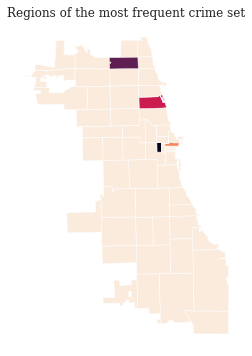

In [149]:
fig, ax = plt.subplots(figsize=(8, 6))
test_df.plot(column='number',cmap = sns.color_palette("rocket_r", as_cmap=True) , linewidth=0.5, scheme = 'FisherJenks', k=5, legend=False , ax=ax)
ax.set_title('Regions of the most frequent crime set', fontsize=12)
ax.axis("off")
plt.savefig('myMap.png',dpi=300, bbox_inches='tight')
plt.show()

In [150]:
train_df

,objectid,shape_area,shape_len,zip,geometry,crime_num,Geography Type,Year,Geography,Population - Total,Population - Age 0-17,Population - Age 18-29,Population - Age 30-39,Population - Age 40-49,Population - Age 50-59,Population - Age 60-69,Population - Age 70-79,Population - Age 80+,Population - Age 0-4,Population - Age 5-11,Population - Age 12-17,Population - Age 5+,Population - Age 18+,Population - Age 65+,Population - Female,Population - Male,Population - Latinx,Population - Asian Non-Latinx,Population - Black Non-Latinx,Population - White Non-Latinx,Population - Other Race Non-Latinx,Record ID,school_num,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,station_num,business,house,level1,level2,level3,level4,level5,level6,gwr_intercept,gwr_sc,gwr_pop,gwr_st,gwr_bus,gwr_house,gwr_density,gwr_population,gwr_level1,gwr_level2,gwr_level3,gwr_level4,gwr_level5,gwr_level6
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",1286,ZIP Code,2018,60647,87509,16298,22356,20993,11055,7700,5309,2695,1103,5924,0.0,0.0,81585,71211,6224,43182,44327,39226,0.0,0.0,38809,0.0,ZIP_Code-60647-2018,14.0,41.92074,-87.70200,Chicago,IL,Illinois,True,0.0,85658.0,8345.9,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago,1.0,880,55.0,163964.0,800482.0,1429785.0,444132.0,463245.0,359119.0,3997.990093,-131.476370,0.076713,1750.075486,-2.153617,-33.634705,0.371085,0.219777,0.065293,0.000179,-0.001784,-0.122196,0.099253,-0.063400
1,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",1286,ZIP Code,2018,60647,87509,16298,22356,20993,11055,7700,5309,2695,1103,5924,0.0,0.0,81585,71211,6224,43182,44327,39226,0.0,0.0,38809,0.0,ZIP_Code-60647-2018,14.0,41.92074,-87.70200,Chicago,IL,Illinois,True,0.0,85658.0,8345.9,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago,1.0,1073,55.0,163964.0,800482.0,1429785.0,444132.0,463245.0,359119.0,3997.990093,-131.476370,0.076713,1750.075486,-2.153617,-33.634705,0.371085,0.219777,0.065293,0.000179,-0.001784,-0.122196,0.099253,-0.063400
2,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",4694,ZIP Code,2018,60639,90517,24573,16203,13873,12852,10387,7660,3539,1430,6633,0.0,0.0,83884,65944,8137,45508,45009,70538,0.0,0.0,6104,0.0,ZIP_Code-60639-2018,16.0,41.92060,-87.75593,Chicago,IL,Illinois,True,0.0,88515.0,6886.9,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago,1.0,818,7.0,233400.0,146301.0,23896.0,499542.0,297870.0,151652.0,4405.990091,-64.822287,0.133558,2972.964933,-2.241579,-12.601261,0.417540,0.345336,-0.003709,-0.017789,-0.001825,-0.119345,0.069266,-0.001927
3,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",4694,ZIP Code,2018,60639,90517,24573,16203,13873,12852,10387,7660,3539,1430,6633,0.0,0.0,83884,65944,8137,45508,45009,70538,0.0,0.0,6104,0.0,ZIP_Code-60639-2018,16.0,41.92060,-87.75593,Chicago,IL,Illinois,True,0.0,88515.0,6886.9,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago,1.0,951,7.0,233400.0,146301.0,23896.0,499542.0,297870.0,151652.0,4405.990091,-64.822287,0.133558,2972.964933,-2.241579,-12.601261,0.417540,0.345336,-0.003709,-0.017789,-0.001825,-0.119345,0.069266,-0.001927
4,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",4346,ZIP Code,2018,60622,52793,8055,14666,15452,6263,3783,2594,1125,855,3540,0.0,0.0,49253,44738,3119,25577,27216,11579,0.0,0.0,34144,0.0,ZIP_Code-60622-2018,16.0,41.90267,-87.68355,Chicago,IL,Illinois,True,0.0,52957.0,8179.1,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago,0.0,814,23.0,82707.0,671070.0,1791438.0,241765.0,335039.0,274501.0,3012.962972,12.110172,0.046907,-139.852647,-2.981830,-18.632706,0.585120,0.130938,0.019855,-0.000502,-0.001040,-0.070199,0.083027,-0.066987
...,...,...,...,.